# Introduction

You have the tools to obtain data from a single table in whatever format you want it. But what if the data you want is spread across multiple tables?

That's where JOIN comes in! JOIN is incredibly important in practical SQL workflows. So let's get started.

# Example
We'll use our imaginary pets table, which has three columns:

- `ID` - ID number for the pet
- `Name` - name of the pet
- `Animal` - type of animal

We'll also add another table, called `owners`. This table also has three columns:

- `ID` - ID number for the owner (different from the ID number for the pet)
- `Name` - name of the owner
- `Pet_ID` - ID number for the pet that belongs to the owner (which matches the ID number for the pet in the `pets` table)
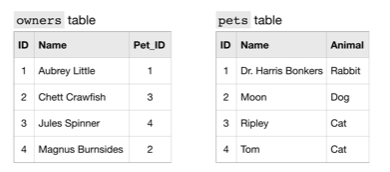
To get information that applies to a certain pet, we match the `ID` column in the `pets` table to the `Pet_ID` column in the owners table.

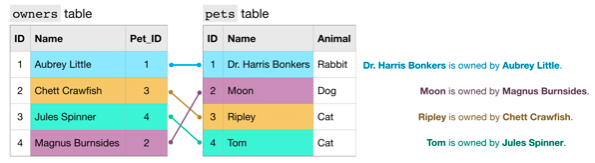
For example,

- the `pets` table shows that Dr. Harris Bonkers is the pet with ID 1.
- The `owners` table shows that Aubrey Little is the owner of the pet with ID 1.

Putting these two facts together, Dr. Harris Bonkers is owned by Aubrey Little.

Fortunately, we don't have to do this by hand to figure out which owner goes with which pet. In the next section, you'll learn how to use **JOIN** to create a new table combining information from the `pets` and `owners` tables.

# JOIN
Using **JOIN**, we can write a query to create a table with just two columns: the name of the pet and the name of the owner.
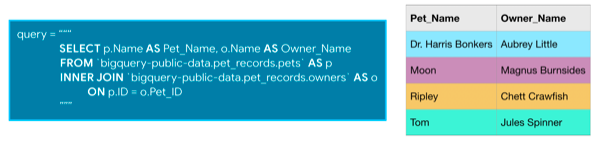
We combine information from both tables by matching rows where the `ID` column in the `pets` table matches the `Pet_ID` column in the `owners` table.

In the query, **ON** determines which column in each table to use to combine the tables. Notice that since the `ID` column exists in both tables, we have to clarify which one to use. We use `p.ID` to refer to the `ID` column from the `pets` table, and `o.Pet_ID` refers to the `Pet_ID` column from the `owners` table.

>In general, when you're joining tables, it's a good habit to specify which table each of your columns comes from. That way, you don't have to pull up the schema every time you go back to read the query.

The type of **JOIN** we're using today is called an **INNER JOIN**. That means that a row will only be put in the final output table if the value in the columns you're using to combine them shows up in both the tables you're joining. For example, if Tom's ID number of 4 didn't exist in the `pets` table, we would only get 3 rows back from this query. There are other types of **JOIN**, but an **INNER JOIN** is very widely used, so it's a good one to start with.

# Example: How many files are covered by each type of software license?

GitHub is the most popular place to collaborate on software projects. A GitHub repository (or repo) is a collection of files associated with a specific project.

Most repos on GitHub are shared under a specific legal license, which determines the legal restrictions on how they are used. For our example, we're going to look at **how many different files have been released under each license**.

We'll work with two tables in the database. The first table is the `licenses` table, which provides the name of each GitHub repo (in the `repo_name` column) and its corresponding license. Here's a view of the first five rows.

In [1]:
from google.cloud import bigquery

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/macbookpro/Documents/5. Kaggle/3. SQL/orbital-caldron-272723-ed30f065fd90.json"

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "github_repos" dataset
dataset_ref = client.dataset("github_repos", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "licenses" table
licenses_ref = dataset_ref.table("licenses")

# API request - fetch the table
licenses_table = client.get_table(licenses_ref)

# Preview the first five lines of the "licenses" table
client.list_rows(licenses_table, max_results=5).to_dataframe()

,repo_name,license
0,Ec313/Photoshop,artistic-2.0
1,viperone/poolsproject,artistic-2.0
2,srmf9/IV-2015-16,artistic-2.0
3,picxenk/TwoLangs,artistic-2.0
4,nanmar/north-american-adventure,artistic-2.0


The second table is the `sample_files` table, which provides, among other information, the GitHub repo that each file belongs to (in the `repo_name` column). The first several rows of this table are printed below.

In [2]:
# Construct a reference to the "sample_files" table
files_ref = dataset_ref.table("sample_files")

# API request - fetch the table
files_table = client.get_table(files_ref)

# Preview the first five lines of the "sample_files" table
client.list_rows(files_table, max_results=5).to_dataframe()

,repo_name,ref,path,mode,id,symlink_target
0,git/git,refs/heads/master,RelNotes,40960,62615ffa4e97803da96aefbc798ab50f949a8db7,Documentation/RelNotes/2.10.0.txt
1,np/ling,refs/heads/master,tests/success/plug_compose.t/plug_compose.ll,40960,0c1605e4b447158085656487dc477f7670c4bac1,../../../fixtures/all/plug_compose.ll
2,np/ling,refs/heads/master,fixtures/strict-par-success/parallel_assoc_lef...,40960,b59bff84ec03d12fabd3b51a27ed7e39a180097e,../all/parallel_assoc_left.ll
3,np/ling,refs/heads/master,fixtures/sequence/parallel_assoc_2tensor2_left.ll,40960,f29523e3fb65702d99478e429eac6f801f32152b,../all/parallel_assoc_2tensor2_left.ll
4,np/ling,refs/heads/master,fixtures/success/my_dual.ll,40960,38a3af095088f90dfc956cb990e893909c3ab286,../all/my_dual.ll


Next, we write a query that uses information in both tables to determine how many files are released in each license.

In [5]:
# Query to determine the number of files per license, sorted by number of files
query = """
        SELECT L.license, COUNT(1) AS number_of_files
        FROM `bigquery-public-data.github_repos.sample_files` AS sf
        INNER JOIN `bigquery-public-data.github_repos.licenses` AS L 
            ON sf.repo_name = L.repo_name
        GROUP BY L.license
        ORDER BY number_of_files DESC
        """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
file_count_by_license = query_job.to_dataframe()

# Print the DataFrame
file_count_by_license

,license,number_of_files
0,mit,20432844
1,gpl-2.0,16867410
2,apache-2.0,7123968
3,gpl-3.0,4936531
4,bsd-3-clause,2943900
5,agpl-3.0,1293773
6,lgpl-2.1,793054
7,bsd-2-clause,694767
8,lgpl-3.0,564433
9,mpl-2.0,473078


# Exercise

# Introduction

[Stack Overflow](https://stackoverflow.com/) is a widely beloved question and answer site for technical questions. You'll probably use it yourself as you keep using SQL (or any programming language). 

Their data is publicly available. What cool things do you think it would be useful for?

Here's one idea:
You could set up a service that identifies the Stack Overflow users who have demonstrated expertise with a specific technology by answering related questions about it, so someone could hire those experts for in-depth help.

In this exercise, you'll write the SQL queries that might serve as the foundation for this type of service.

In [6]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "stackoverflow" dataset
dataset_ref = client.dataset("stackoverflow", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Exercises

### 1) Explore the data

Before writing queries or **JOIN** clauses, you'll want to see what tables are available. 

*Hint*: Tab completion is helpful whenever you can't remember a command. Type `client.` and then hit the tab key. Don't forget the period before hitting tab.

In [8]:
# List all the tables in the dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset (there is only one!)
for table in tables:  
    print(table.table_id)

badges
comments
post_history
post_links
posts_answers
posts_moderator_nomination
posts_orphaned_tag_wiki
posts_privilege_wiki
posts_questions
posts_tag_wiki
posts_tag_wiki_excerpt
posts_wiki_placeholder
stackoverflow_posts
tags
users
votes


### 2) Review relevant tables

If you are interested in people who answer questions on a given topic, the `posts_answers` table is a natural place to look. Run the following cell, and look at the output.

In [9]:
# Construct a reference to the "posts_answers" table
answers_table_ref = dataset_ref.table("posts_answers")

# API request - fetch the table
answers_table = client.get_table(answers_table_ref)

# Preview the first five lines of the "posts_answers" table
client.list_rows(answers_table, max_results=5).to_dataframe()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,20961156,None,"<p>I figured it out on my own, I think:</p>\n\...",None,None,0,NaT,2014-01-06 23:22:13.043000+00:00,None,2014-01-06 23:31:28.093000+00:00,2014-01-06 23:31:28.093000+00:00,None,2438423.0,None,2438423,20940483,2,0,None,None
1,20961162,None,<pre><code>WHERE post_content LIKE 'www.exampl...,None,None,0,NaT,2014-01-06 23:22:55.477000+00:00,None,2014-01-06 23:22:55.477000+00:00,NaT,None,NaN,None,3165602,20959992,2,0,None,None
2,20961163,None,"<pre><code>if (choice1 === ""rock"") {\n if (...",None,None,0,NaT,2014-01-06 23:22:59.443000+00:00,None,2014-01-06 23:22:59.443000+00:00,NaT,None,NaN,None,57135,20961119,2,0,None,None
3,20961171,None,"<p>Your ""brute force"" search is usually called...",None,None,0,NaT,2014-01-06 23:23:48.903000+00:00,None,2014-01-06 23:23:48.903000+00:00,NaT,None,NaN,None,91757,20960751,2,0,None,None
4,20961197,None,"<p>I would take a look at either <a href=""http...",None,None,0,NaT,2014-01-06 23:26:39.027000+00:00,None,2014-01-06 23:26:39.027000+00:00,NaT,None,NaN,None,2027567,20961131,2,0,None,None


It isn't clear yet how to find users who answered questions on any given topic. But `posts_answers` has a `parent_id` column. If you are familiar with the Stack Overflow site, you might figure out that the `parent_id` is the question each post is answering.

Look at `posts_questions` using the cell below.

In [10]:
# Construct a reference to the "posts_questions" table
questions_table_ref = dataset_ref.table("posts_questions")

# API request - fetch the table
questions_table = client.get_table(questions_table_ref)

# Preview the first five lines of the "posts_questions" table
client.list_rows(questions_table, max_results=5).to_dataframe()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,34307193,Reuse of WCF Binding class instances,<p>I create NetTcpBinding-s on application's c...,NaN,1,0,NaT,2015-12-16 08:32:50.587000+00:00,NaN,2015-12-20 23:32:52.530000+00:00,NaT,None,NaN,None,5152658,None,1,1,c#|wcf|wcf-binding|channelfactory|webchannelfa...,256
1,34333301,Upgrade to Free jqGrid 4.11 - inline edit with...,<p>The grid defines the field as:</p>\n\n<pre>...,34335032.0,1,0,NaT,2015-12-17 11:20:19.803000+00:00,1.0,2015-12-18 10:23:35.380000+00:00,2015-12-18 10:23:35.380000+00:00,None,470383.0,None,470383,None,1,2,jquery|jqgrid,256
2,34342966,Obscuring Default Plaintext password in Powers...,<p>I am working on a PowerCLI script that depl...,34343477.0,1,0,NaT,2015-12-17 19:43:01.430000+00:00,NaN,2015-12-17 20:15:31.240000+00:00,NaT,None,NaN,None,2373838,None,1,1,passwords|powercli,256
3,34349579,If/Else TextView actions iOS,<p>I have a <code>textview</code> in my <code>...,NaN,6,0,NaT,2015-12-18 06:20:09.150000+00:00,NaN,2015-12-18 07:26:54.473000+00:00,2015-12-18 06:44:37.900000+00:00,None,1508398.0,None,5588068,None,1,1,ios|objective-c,256
4,34373960,SpriteKit physics bodies not colliding when co...,<p>I am evaluating the iOS SpriteKit physics e...,NaN,1,0,NaT,2015-12-19 18:26:28.850000+00:00,1.0,2015-12-21 10:35:25.100000+00:00,2015-12-19 19:08:02.887000+00:00,None,1240557.0,None,1157345,None,1,3,ios|collision|skphysicsbody|skscene,256


`posts_questions` has a column called `tags` which lists the topics/technologies each question is about.
`posts_answers` has a column called `parent_id` which identifies the ID of the question each answer is responding to. `posts_answers` also has an `owner_user_id` column which specifies the ID of the user who answered the question.

You can join these two tables to:
- determine the tags for each answer, and then
- select the `owner_user_id` of the answers on the desired tag.

This is exactly what you will do over the next few questions.

### 3) Selecting the right questions

A lot of this data is text. 

We'll explore one last technique in this course which you can apply to this text.

A **WHERE** clause can limit your results to rows with certain text using the **LIKE** feature. For example, to select just the third row of the `pets` table from the tutorial, we could use the query in the picture below.

![](https://i.imgur.com/RccsXBr.png) 

You can also use `%` as a "wildcard" for any number of characters. So you can also get the third row with:

```
query = """
        SELECT * 
        FROM `bigquery-public-data.pet_records.pets` 
        WHERE Name LIKE '%ipl%'
        """
```

Try this yourself. Write a query that selects the `id`, `title` and `owner_user_id` columns from the `posts_questions` table. 
- Restrict the results to rows that contain the word "bigquery" in the `tags` column. 
- Include rows where there is other text in addition to the word "bigquery" (e.g., if a row has a tag "bigquery-sql", your results should include that too).

In [19]:
# Your code here
questions_query = """
                  SELECT id, title, owner_user_id
                  FROM `bigquery-public-data.stackoverflow.posts_questions`
                  WHERE tags LIKE '%bigquery%'
                  """

# Set up the query (cancel the query if it would use too much of your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
questions_query_job = client.query(questions_query, job_config=safe_config)

# API request - run the query, and return a pandas DataFrame
questions_results = questions_query_job.to_dataframe()

# Preview results
print(questions_results.head())

         id                                              title  owner_user_id
0  54007400  IAM Custom Role for Inserting to Specific BigQ...      7393707.0
1  54299820  Assign incremental value to multiple entries w...      9941132.0
2  54109779           Firebase performance data with big query      7893736.0
3  54195300         Firebase: Filtrating Events key and values     10915857.0
4  54155753  Error using Dataproc and Spark BigQuery Connec...      2844527.0


### 4) Your first join
Now that you have a query to select questions on any given topic (in this case, you chose "bigquery"), you can find the answers to those questions with a **JOIN**.  

Write a query that returns the `id`, `body` and `owner_user_id` columns from the `posts_answers` table for answers to "bigquery"-related questions. 
- You should have one row in your results for each answer to a question that has "bigquery" in the tags.  
- Remember you can get the tags for a question from the `tags` column in the `posts_questions` table.

Here's a reminder of what a **JOIN** looked like in the tutorial:
```
query = """
        SELECT p.Name AS Pet_Name, o.Name AS Owner_Name
        FROM `bigquery-public-data.pet_records.pets` as p
        INNER JOIN `bigquery-public-data.pet_records.owners` as o 
            ON p.ID = o.Pet_ID
        """
```

It may be useful to scroll up and review the first several rows of the `posts_answers` and `posts_questions` tables.  

In [23]:
answers_query = """
                SELECT a.id, a.body, a.owner_user_id
                FROM `bigquery-public-data.stackoverflow.posts_questions` AS q 
                INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` AS a
                    ON q.id = a.parent_id
                WHERE q.tags LIKE '%bigquery%'
                """

# Set up the query (cancel the query if it would use too much of your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
answers_query_job = client.query(answers_query, job_config=safe_config)

# API request - run the query, and return a pandas DataFrame
answers_results = answers_query_job.to_dataframe()

# Preview results
print(answers_results.head())

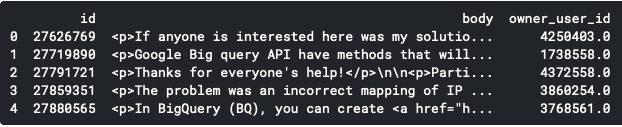

### 5) Answer the question
You have the merge you need. But you want a list of users who have answered many questions... which requires more work beyond your previous result.

Write a new query that has a single row for each user who answered at least one question with a tag that includes the string "bigquery". Your results should have two columns:
- `user_id` - contains the `owner_user_id` column from the `posts_answers` table
- `number_of_answers` - contains the number of answers the user has written to "bigquery"-related questions

In [26]:
bigquery_experts_query = """
                         SELECT a.owner_user_id AS user_id, COUNT(1) AS number_of_answers
                         FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
                         INNER JOIN `bigquery-public-data.stackoverflow.posts_answers` AS a
                             ON q.id = a.parent_Id
                         WHERE q.tags LIKE '%bigquery%'
                         GROUP BY a.owner_user_id
                         ORDER BY number_of_answers DESC
                         """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
bigquery_experts_query_job = client.query(bigquery_experts_query, job_config=safe_config)

# API request - run the query, and return a pandas DataFrame
bigquery_experts_results = bigquery_experts_query_job.to_dataframe()

# Preview results
print(bigquery_experts_results.head())

     user_id  number_of_answers
0  5221944.0               2750
1   132438.0                761
2  6253347.0                736
3  1366527.0                617
4  1144035.0                616
